# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [2]:
# !pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [4]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [5]:
print(os.environ["LANGCHAIN_PROJECT"])

## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [6]:
# 😉 We don't need this cause we run thin on VS code
# from google.colab import files
# uploaded = files.upload()

In [2]:
# file_path = list(uploaded.keys())[0]
# file_path


file_path = 'Extending Llama-3s Context Ten-Fold Overnight.pdf' # 😉 My own pdf file

We'll define our chunking strategy.

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"{file_path}_{i}"

In [5]:
# 🚀 My own cell
len(docs)

16

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

### 🚀 LangChain's CacheBackedEmbeddings
- [Link](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.cache.CacheBackedEmbeddings.html#langchain-embeddings-cache-cachebackedembeddings)

### 🚀 LangChain's LocalFileStore
- [Link](https://api.python.langchain.com/en/latest/storage/langchain.storage.file_system.LocalFileStore.html#langchain.storage.file_system.LocalFileStore)

In [6]:
# 🚀 My own cell
from langchain.storage import LocalFileStore

file_store = LocalFileStore(root_path = "root_path")

# Store key-value pairs (not str but bytes)
file_store.mset( [("key1", b"value1"), ("key2", b"value2")]  )


# Get values
values = file_store.mget(["key1", "key2"])  # Returns [b"value1", b"value2"]

# Delete keys
file_store.mdelete(["key1"])


# Iterate over keys
for key in file_store.yield_keys():
    print(key)  # noqa: T201


key2


In [7]:
import uuid
from qdrant_client import QdrantClient # 😉 This is not related to LangChain
from qdrant_client.models import VectorParams, Distance
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore

from langchain.storage import LocalFileStore  # 😉 Interface for local file system
from langchain.embeddings import CacheBackedEmbeddings  # 😉 Interface for caching results from embedding models.

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up 
collection_name = f"pdf_to_parse_{ file_path.split('.pdf')[0].strip().replace(' ', '') }"  # 😉 Interface

# client = QdrantClient(":memory:")
client = QdrantClient("http://localhost:6333") # 😉 Use docker container

if collection_name not in (x.name for x in client.get_collections().collections):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
    )
    # Adding cache!
    store = LocalFileStore("./cache/")
    cached_embedder = CacheBackedEmbeddings.from_bytes_store(
        underlying_embeddings = core_embeddings, 
        document_embedding_cache = store, 
        namespace=core_embeddings.model  # 😉 This namespace is used to avoid collisions with other caches (Use the name of the embedding model used).
    )

# Typical QDrant Vector Store Set-up  # 😉 From an existing collection

# 😉 LangChain Qdrant vectorstore
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder
    )

# 😉 populate with docs and check the number of points (Expected to be 16 since len()=16)
vectorstore.add_documents(docs)
print(f"Number of points in collection {collection_name}: {client.count(collection_name=collection_name)}")


retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

Number of points in collection pdf_to_parse_ExtendingLlama-3sContextTen-FoldOvernight: count=16


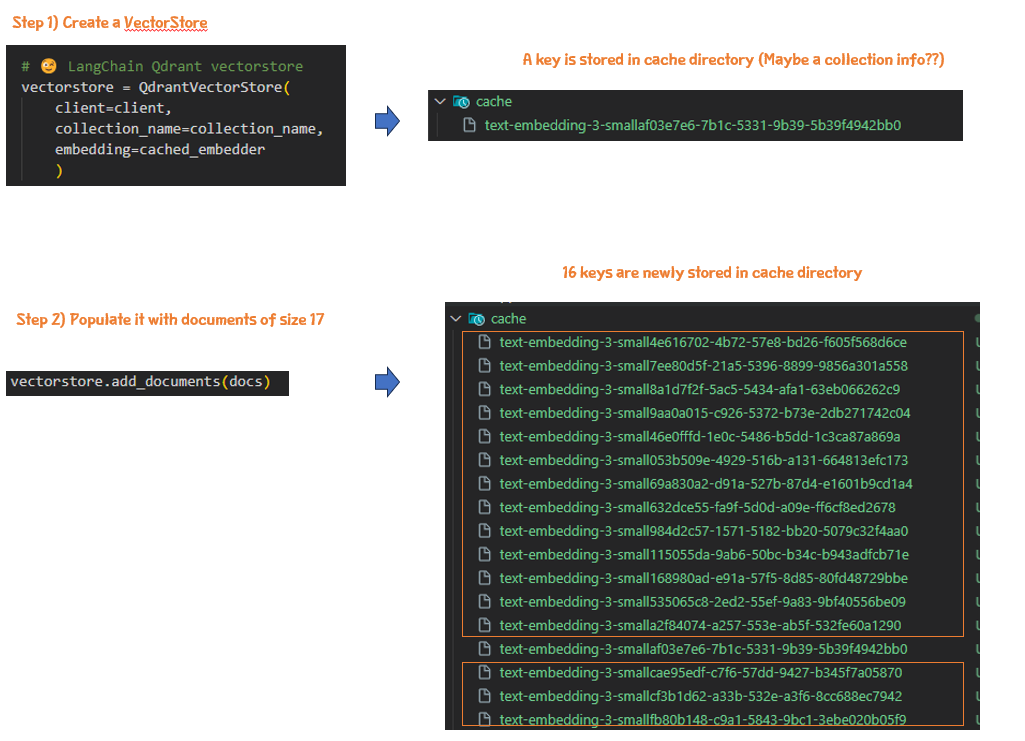

In [8]:
# 🚀 My own cell
print(client == vectorstore.client)

# Count the number of points (nodes)
client.count(collection_name=collection_name)

True


CountResult(count=16)

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🚀 Answer to  Question #1 (I missed breakout room so discussed with ChatGPT):
1. Limitations
- Limitation 1 - Storage Overhead
    - The cache (stored locally) grows as more documents are processed, especially with large datasets or many different queries.
    - How to mitigate this? Periodically clear or compress the cache, or selectively cache frequently accessed embeddings.

- Limitation 2 - Cache Invalidity
    - If documents are updated or the model itself is updated (e.g., moving from one version of OpenAI embeddings to another), cached embeddings may become stale or invalid.
    - How to mitigate this? Implement version control for embedding models and cache invalidation strategies based on document updates or model changes.

- Limitation 3 - Cold Start for New Data
    - Caching only speeds up repeated requests for the same or similar content. For new documents or first-time queries, there’s still a need to compute and store the embeddings.
    - How to mitigate this?  Use caching in environments where repeated queries over the same data are expected.

2. Most useful cases
- Frequent Reuse of the Same Data
- High Embedding Costs
- Low Data Volatilit



3. Least useful cases (Almost the opposite cases of Most useful cases)
- High Data Volatility
- Large, Diverse Datasets with Few Repeated Queries
- Small Dataset with Low Embedding Costs (Caching adds additional complexity)

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [9]:
### YOUR CODE HERE

# 😉 See the relationship between cache directory and embedding
cache_folder = "cache"
num_of_points_in_vectorstore = client.count(collection_name=collection_name).count
num_of_stored_points_in_chache = len([f for f in os.listdir(cache_folder) if os.path.isfile(os.path.join(cache_folder, f))  ]) -1

assert num_of_points_in_vectorstore == num_of_stored_points_in_chache

# 😉 Populate it with the same docs again
vectorstore.add_documents(docs)
num_of_points_in_vectorstore = client.count(collection_name=collection_name).count
num_of_stored_points_in_chache = len([f for f in os.listdir(cache_folder) if os.path.isfile(os.path.join(cache_folder, f))  ]) -1
assert num_of_points_in_vectorstore == num_of_stored_points_in_chache * 2  # Even though the number of points in the vectorstore is doubled, cache is not doubled


In [10]:
### YOUR CODE HERE

# 😉 Populate the vectorstore with differennt docs
from langchain_community.document_loaders import PyMuPDFLoader

file_path_2 = 'Demonstrate_Search_Predict_Composing_retrieval_and_language_models_for_knowledge_intensive_NLP.pdf.pdf' 

documents_2 = PyMuPDFLoader(file_path_2).load()
docs_2 = text_splitter.split_documents(documents_2)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"{file_path_2}_{i}"

print(f"num_of_docs: {len(docs_2)}")

vectorstore.add_documents(docs_2)
num_of_stored_points_in_chache = len([f for f in os.listdir(cache_folder) if os.path.isfile(os.path.join(cache_folder, f))  ]) -1

assert num_of_stored_points_in_chache == len(docs_2)+ len(docs)  # Caching is done only for differnt chunks


num_of_docs: 86


In [11]:
# 🚀 My own cell
# Refresh the vectorstore and retriever such that they're only related to the original docs 

if collection_name in (x.name for x in client.get_collections().collections):
    client.delete_collection(collection_name=collection_name)

    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
    )
    
    store = LocalFileStore("./cache/")
    cached_embedder = CacheBackedEmbeddings.from_bytes_store(
        underlying_embeddings = core_embeddings, 
        document_embedding_cache = store, 
        namespace=core_embeddings.model 
    )

    vectorstore = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=cached_embedder
        )

    vectorstore.add_documents(docs)

    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [13]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [18]:
from langchain_core.caches import InMemoryCache

# set_llm_cache(InMemoryCache()) # 😉 Instead of in-memory cache, I will use 

from langchain_community.cache import SQLiteCache
if not os.path.exists("langchain_cache"): os.mkdir("langchain_cache")
set_llm_cache(SQLiteCache(database_path="langchain_cache/sqlite_cache.db"))

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🚀 Answer to  Question #2 (I missed breakout room so discussed with ChatGPT):
1. Limitations
- Limitation 1 - Limited by Available Memory (RAM)
    - Since the cache is stored in memory, the amount of data you can store is constrained by the available RAM.
    - How to mitigate this? Use disk-based or distributed caching solutions for larger datasets (e.g., Redis, or a file-based cache)

- Limitation 2 - Stale Response
    - By using caching, we get to get always the same answer for the same question. This is bad for some situations.
    - How to mitigate this? Add a component which changes the cached response a little bit to add some spice.

- Limitation 3 - Increased Complexity
    - Adding a caching layer increases the overall complexity of the system. 
    - Keep the caching strategy simple or use mature caching libraries with built-in management features

2. Most useful cases
- Frequent Repeated Queries
- Expensive or Time-Consuming LLM responses


3. Least useful cases 
- Situations where we need creativity rather than accurate answer 
- Low-cost, low-latency applications

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed ~~embeddings~~ llm.

In [19]:
### YOUR CODE HERE
import time

# 😉 new question
start_time = time.time()
new_question = "What are the advantages of using LlamaIndex?"
print(chat_model.invoke(new_question).content)
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)


# 😉 the same question -> cache
start_time = time.time()
new_question = "What are the advantages of using LlamaIndex?"
print(chat_model.invoke(new_question).content)
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)


# 😉 new question -> no cache
start_time = time.time()
new_question = "What are the main differences between LlamaIndex and LangChain?"
print(chat_model.invoke(new_question).content)
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)

LlamaIndex (formerly known as GPT Index) is a framework designed to facilitate the integration of large language models (LLMs) with various data sources. It provides several advantages for developers and organizations looking to leverage LLMs effectively. Here are some of the key advantages:

1. **Data Integration**: LlamaIndex allows users to connect various types of data sources, such as databases, documents, and APIs, making it easier to pull relevant information for LLMs to process.

2. **Indexing Capabilities**: The framework offers indexing functionalities that help in organizing and optimizing data for faster retrieval. This can significantly enhance the performance of LLMs when answering queries or generating content.

3. **Customizability**: Users can customize how data is indexed and retrieved, allowing for tailored solutions that fit specific use cases or organizational needs.

4. **Efficiency**: By structuring data effectively, LlamaIndex reduces the overhead of processing 

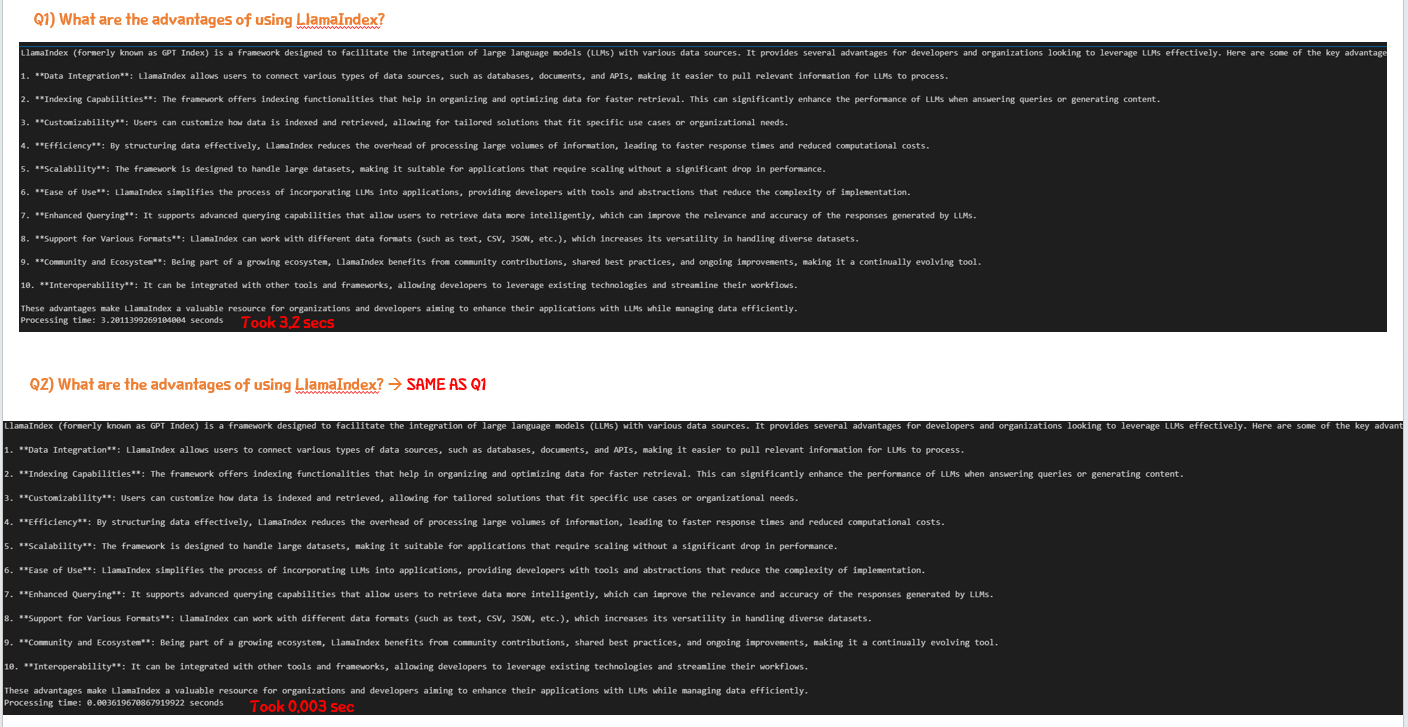 

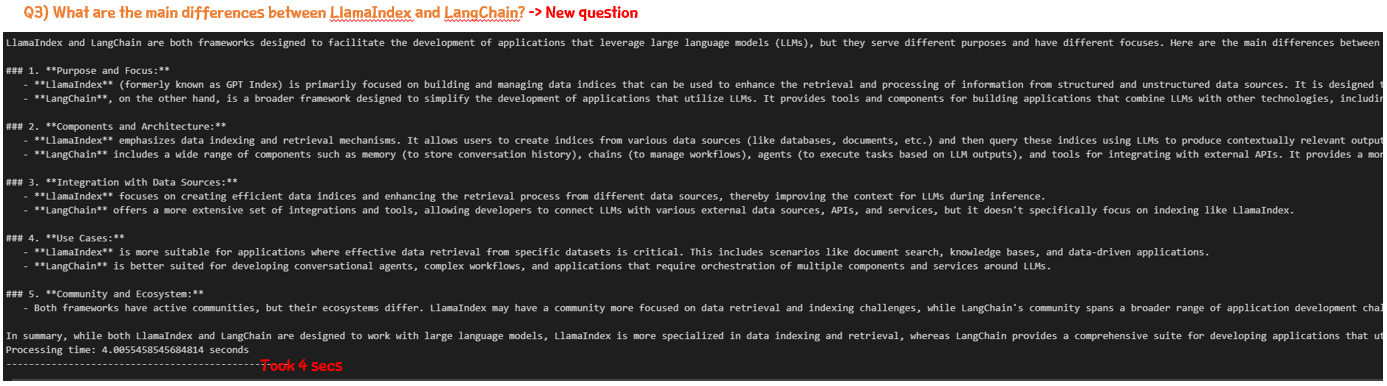

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [21]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [22]:
start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
print(response.content)
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)

start_time = time.time()
response = retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
print(response.content)
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)

1. The document is titled "Extending Llama-3's Context Ten-Fold Overnight."
2. It is a PDF document with 5 total pages.
3. The document was created using LaTeX with hyperref.
4. The producer of the document is pdfTeX-1.40.25.
5. The creation date of the document is May 1, 2024.
6. The modification date is also May 1, 2024.
7. The document's content discusses long-context large language models (LLMs).
8. It focuses specifically on extending the context length of Llama-3-8B-Instruct from 8K to 80K tokens.
9. The document includes multiple references to related research papers.
10. It mentions a team of authors, including I. Molybog, Y. Nie, and others.
11. The document provides evaluation metrics based on conversations of varying topic lengths.
12. It states that Llama-3-8B-Instruct fails to remember topics beyond a context length of 9K.
13. In contrast, the proposed model maintains 100% accuracy across all context lengths evaluated.
14. The document suggests that the original context le

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

##### 🚀 End-to-end caching

I am not sure if my implementation below is optimal (probably not) but I tried.

In [23]:
# 🚀 My own cell
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough
from langchain_core.messages import AIMessage
from langchain.storage import LocalFileStore
import re
import ast
from langchain_core.runnables import RunnableLambda


def clean_text(text: str) -> str:    
    return re.sub(r'[^a-zA-Z0-9]', '', text)

# 😉 Caching RAG response
def caching_rag_respnse(response: AIMessage):
    file_store = LocalFileStore(root_path = "e2e_rag_cache")
    question = clean_text(response['question'])
    answer = response['answer'].content.encode('utf-8')

    file_store.mset( [(question, answer)]  )

# 😉 Load cached RAG response
def load_cached_response(input: dict) :
    assert "question" in input, "The input dictionary must have a key 'question'" 
    file_store = LocalFileStore(root_path = "e2e_rag_cache")
    
    question = clean_text(input['question']) 
    cached_answer = file_store.mget([question])[0]
    if cached_answer:
        return cached_answer.decode('utf-8')
    else:
        return False

# 😉 RAG chain that caches the response
retrieval_augmented_qa_chain_caching_response = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")} |
        RunnablePassthrough.assign( answer = chat_prompt | chat_model  ) | 
        RunnablePassthrough( lambda x: caching_rag_respnse(x) ) |
        RunnableLambda( lambda x: x['answer'].content )
)


# 😉 End-toend RAG chain that leverages cache
retrieval_augmented_qa_chain_with_e2e_cache = (
        RunnablePassthrough.assign( cached_answer = lambda x: load_cached_response(x)  ) |
        RunnableLambda(lambda x: x['cached_answer'] if x['cached_answer'] else retrieval_augmented_qa_chain_caching_response.invoke(x)) 
    )



In [24]:
question_1 = "Write 50 things about this document!"
question_2 = "What is the main takeaway from this paper?"


start_time = time.time()
answer = retrieval_augmented_qa_chain_with_e2e_cache.invoke({"question" : question_1})
print(f"question_1: {question_1}")
print(f"answer: {answer[:200]}")
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)

start_time = time.time()
answer = retrieval_augmented_qa_chain_with_e2e_cache.invoke({"question" : question_1})
print(f"question_1: {question_1}")
print(f"answer: {answer[:200]}")
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)


start_time = time.time()
answer = retrieval_augmented_qa_chain_with_e2e_cache.invoke({"question" : question_2})
print(f"question_1: {question_2}")
print(f"answer: {answer[:200]}")
elapsed_time = time.time() - start_time
print(f"Processing time: {elapsed_time} seconds")
print("-"*50)

question_1: Write 50 things about this document!
answer: 1. The document is titled "Extending Llama-3's Context Ten-Fold Overnight."
2. It is a PDF document with 5 total pages.
3. The document was created using LaTeX with hyperref.
4. The producer of the do
Processing time: 0.39542126655578613 seconds
--------------------------------------------------
question_1: Write 50 things about this document!
answer: 1. The document is titled "Extending Llama-3's Context Ten-Fold Overnight."
2. It is a PDF document with 5 total pages.
3. The document was created using LaTeX with hyperref.
4. The producer of the do
Processing time: 0.002997159957885742 seconds
--------------------------------------------------
question_1: What is the main takeaway from this paper?
answer: The main takeaway from the paper is the introduction of an efficient solution that significantly extends the context length of the Llama-3-8B-Instruct model from 8K to 80K tokens, demonstrating that l
Processing time: 1.61978268